In [1]:
import os

from Architectures import *
import random, os


import ROOT
from ROOT import TLorentzVector

import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

from tqdm import trange

2022-12-20 13:59:57.030262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 13:59:57.030300: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.22/08


In [2]:
#Training parameters
EPOCHS = 16
learning_rate = 1e-3
loss = tf.keras.losses.CategoricalCrossentropy()

#Set seed for reproducability
os.environ['PYTHONHASHSEED']=str(0)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)



#Input data filename. contents of data file below described in README
filename = 'data/data80k_raw_combined_atlas_cut.pkl'

In [3]:
def gen_dataset(inp, oup, events_tag, pad_n=15,):
    #takes in input generated from Madgraph+Pythia+Delphes and outputs
    #dataset with shape (N_events, pad_n, N_features)
    X = []
    y = []
    
    max_rag = -1
    for event_idx in trange(len(inp)):
        curr_parts = []
        curr_oup = []

        #get some features for the current event
        curr_event_tag = events_tag[event_idx][0]
        curr_oup = [curr_event_tag==0, curr_event_tag==1]
        curr_oup = list(map(int, curr_oup))

        temp_parts = [part for part in inp[event_idx]]
        temp_parts_pt = [part[0].Perp() for part in inp[event_idx]]
        sort_idxs = np.argsort(temp_parts_pt)[::-1]
        temp_parts = np.array(temp_parts)[sort_idxs]

        n_parts = len(temp_parts)

        #get some global quantities from event
        partP4_tot = TLorentzVector()
        partPT_tot = 0
        partM_tot = 0

        for part_idx in range(n_parts):
            temp_part_P4 = temp_parts[part_idx][0]
            partP4_tot += temp_part_P4
            partPT_tot += temp_part_P4.Perp()
            partM_tot += np.abs(temp_part_P4.M())

        part_idxs = [i for i in range(n_parts)]

        for part_idx in range(n_parts):
            partP4 = temp_parts[part_idx][0]

            #get kinematics
            partE = partP4.E()
            partPT = partP4.Perp()
            party = partP4.PseudoRapidity()
            partP = partP4.Phi()
            partM = np.abs(partP4.M())

            #get btag and tautag
            part_btags = temp_parts[part_idx][1]
            part_tautags = temp_parts[part_idx][2]
            
            eps = 1e-4 #small epsilon
            #generate features to represent a particle
            curr_part = [np.log(partE/partP4_tot.E()), 
                         np.log(eps+partM/partM_tot), 
                         party,
                         partP, 
                         np.log(partPT/partPT_tot), 
                         part_btags,
                         part_tautags]
            
            curr_parts.append(curr_part)
            
        X.append(curr_parts)
        max_rag = max(max_rag, len(curr_parts))
        y.append(curr_oup)    
        
    X = tf.keras.preprocessing.sequence.pad_sequences(X, dtype='float32', padding='post', maxlen=pad_n)
    return X,y


In [4]:
#now we can load in the data file
inpfile = open(filename, 'rb')
events, events_oup, events_tag  = pickle.load(inpfile)
inpfile.close()

events = np.array(events)
events_oup = np.array(events_oup)
events_tag = np.array(events_tag)

#generate train test split
split = 0.7
indices = np.random.permutation(len(events))
split_len = int(len(events)*split)
training_idx, test_idx = indices[:split_len], indices[split_len:]

#these variables contain the raw information about the event from Madgraph+Pythia+Delphes
events_train, events_test = events[training_idx], events[test_idx]
events_oup_train, events_oup_test = events_oup[training_idx], events_oup[test_idx]
events_tag_train, events_tag_test = events_tag[training_idx], events_tag[test_idx]

#we want to take the information and put it into 
#  input: tensor of dimensions (N_events, NPAD, N_features) 
#    where NPAD is some number > the maximum number of objects in an event.
#    in principle the architecture are defined on variable length lists 
#    but in practice to efficinetly handle large datasets of variable length lists
#    we must pad the lists so that we have a rectangular tensor and use masking layers
#    to handle the variable length nature of our data
#  output: tensor of dimensions (N_events, 2)

X_train, y_train = gen_dataset(events_train, events_oup_train, events_tag_train)
                                              
X_test, y_test   = gen_dataset(events_test, events_oup_test, events_tag_test)
                                              
X_train = tf.constant(X_train) 
y_train = tf.constant(y_train)
X_test  = tf.constant(X_test)
y_test  = tf.constant(y_test)

/tmp/ipykernel_1439385/324934486.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  events = np.array(events)
/tmp/ipykernel_1439385/324934486.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  events_oup = np.array(events_oup)
100%|██████████| 48000/48000 [00:08<00:00, 5399.86it/s]
2022-12-20 14:00:47.394756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-20 14:00:47.395052: W tensorflow/stream_exec

In [5]:
#now we create a Pairwise architecture defined in Architectures.py
classifier = Pairwise(depth=3, width=32, ec_widths=(32,64,32))

#in the following lines we are getting everything together to start training the classifier
opt = tf.keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate)
classifier.compile(loss=loss, optimizer=opt)

#and now we can train the classifier
classifier.fit(X_train, y_train, verbose=2, epochs=EPOCHS)

Epoch 1/16
3500/3500 - 15s - loss: 0.4214
Epoch 2/16
3500/3500 - 14s - loss: 0.3822
Epoch 3/16
3500/3500 - 13s - loss: 0.3720
Epoch 4/16
3500/3500 - 13s - loss: 0.3659
Epoch 5/16
3500/3500 - 13s - loss: 0.3616
Epoch 6/16
3500/3500 - 14s - loss: 0.3571
Epoch 7/16
3500/3500 - 14s - loss: 0.3542
Epoch 8/16
3500/3500 - 14s - loss: 0.3505
Epoch 9/16
3500/3500 - 14s - loss: 0.3472
Epoch 10/16
3500/3500 - 14s - loss: 0.3441
Epoch 11/16
3500/3500 - 14s - loss: 0.3416
Epoch 12/16
3500/3500 - 14s - loss: 0.3398
Epoch 13/16
3500/3500 - 14s - loss: 0.3371
Epoch 14/16
3500/3500 - 14s - loss: 0.3349
Epoch 15/16
3500/3500 - 14s - loss: 0.3328
Epoch 16/16
3500/3500 - 14s - loss: 0.3309


2022-12-20 14:00:47.889301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-20 14:00:47.889991: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397305000 Hz


In [6]:
classifier.summary()

Model: "pairwise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
edge_conv_layer (EdgeConvLay multiple                  4672      
_________________________________________________________________
my_activation_3 (MyActivatio multiple                  0 (unused)
_________________________________________________________________
adder (adder)                multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1056      
_________________________________________________________________
dense_1 (Dense)              multiple                  1056      
_________________________________________________________________
dense_2 (Dense)              multiple                  1056      
_________________________________________________________________
dense_3 (Dense)              multiple                  66 

/tmp/ipykernel_1439385/3921549547.py:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='black', label=r'AUC: %.3f'%(auc))


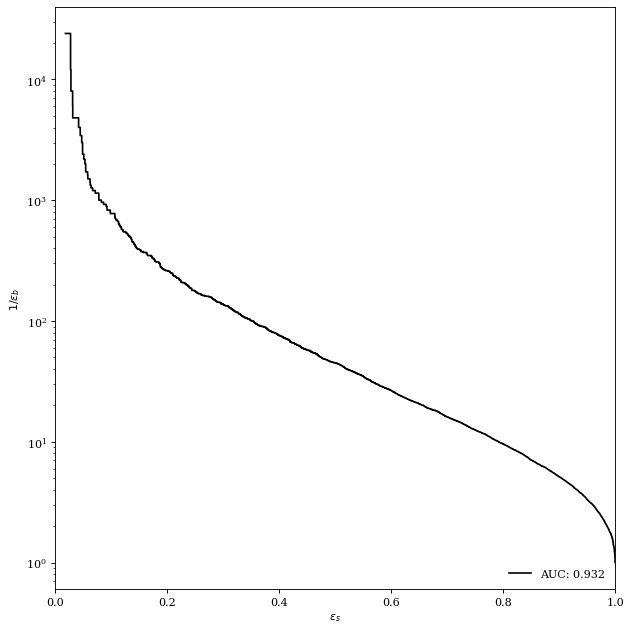

In [7]:
#Lets visualize the performance of this architecture on the test dataset
from sklearn import metrics


matplotlib.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] = True


#First we will get the predictions of the classifier on the test dataset
yhat_test = classifier.predict(X_test)

#next we flatten everything so that we can get the ROC
yhat_test = np.array([prob_ttH for (prob_ttH, prob_ttbar) in yhat_test])
y0_test   = np.array([prob_ttH for (prob_ttH, prob_ttbar) in y_test.numpy()])

#and now we can get the ROC
fpr, tpr, thresholds = metrics.roc_curve(y0_test, yhat_test) 
auc = metrics.auc(fpr, tpr)

#lets plot the ROC curve
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(tpr, 1/fpr, color='black', label=r'AUC: %.3f'%(auc))
plt.xlim([0.0, 1.0])
plt.xlabel(r'$\epsilon_s$')
plt.ylabel(r'$1/\epsilon_b$')
plt.yscale('log')
plt.legend(loc='lower right', frameon=False)


In [8]:
#Lets generate the visualization of the latent dimension using t-SNE seen in the paper
#first we need to extract the part of the Edge+Inv network that gives us the latent representation of the 
#collider event
latent_getter = LatentGetter(classifier.layers[0:3], condensed=True)

#first lets randomly select 2000 events in our dataset
n_cut = 2000
indices = np.random.permutation(len(X_test))
cut = np.s_[indices[:n_cut]]

#from here we we use t-SNE to get the reduce the dimensions of jets to two dimensions
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

latent_reps = latent_getter.predict(X_test.numpy()[cut])
latent_label = y_test.numpy()[cut]

#compute cosine distances
distance_matrix = pairwise_distances(latent_reps, latent_reps, metric='cosine', n_jobs=-1)
latent_reps_embedded_tsne = TSNE(metric="precomputed", n_components=2, learning_rate='auto', 
                                  verbose=2, perplexity=50, n_jobs=-1)
latent_reps_embedded = latent_reps_embedded_tsne.fit_transform(distance_matrix)

/home/delon/.conda/envs/pcec/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.030s...
[t-SNE] Computed neighbors for 2000 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.033096
[t-SNE] Computed conditional probabilities in 0.242s
[t-SNE] Iteration 50: error = 72.2426529, gradient norm = 0.0002337 (50 iterations in 1.238s)
[t-SNE] Iteration 100: error = 69.9278717, gradient norm = 0.0001390 (50 iterations in 1.349s)
[t-SNE] Iteration 150: error = 69.9179382, gradient norm = 0.0000058 (50 iterations in 1.242s)
[t-SNE] Iteration 200: error = 69.9179230, gradient norm = 0.0000058 (50 iterations in 1.307s)
[t-SNE] Iteration 250: error = 69.9179230, gradient norm = 0.0000060 (50 iterations in 1.289s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.917923
[t-SNE] Iteration 300: error = 1.9359940, gradient norm = 0.0035340 (50 iterations in 1.331s

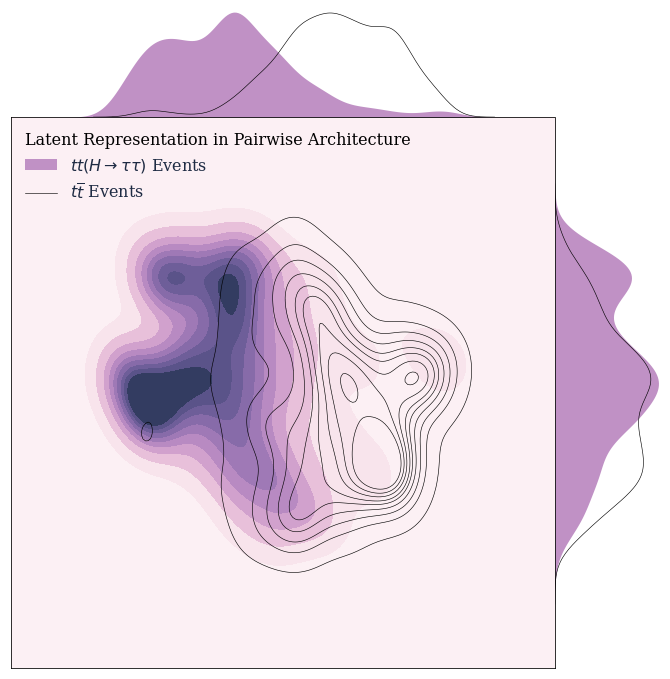

In [9]:
import seaborn as sns


#Defining some things for color
c_cut = 5
cmap = sns.cubehelix_palette(start=26/10, light=.97, as_cmap=True)

#for the 
#a e s t h e t i c s
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] = False

curr_event = latent_reps_embedded


#plot the joint density plot + marginal for ttH events
ttH_loc = np.array([curr_event[i] for i in range(len(latent_label)) if latent_label[i][1]==1])
g = sns.jointplot(x=ttH_loc[:,0], y = ttH_loc[:,1], color=cmap(100), space=0, label='ttH jets',
                  cmap=cmap, kind='kde', height=10, fill=True, cut=c_cut,
                 marginal_kws={'linewidth': 0.0, 'alpha':1.0})


#define some vanity parameters for ttbar density 
COL2 = '#000000'
linew = 0.6

#plotting ttbar densities
nttH_loc = np.array([curr_event[i] for i in range(len(latent_label)) if latent_label[i][0]==1])

#joint 2D density plot
sns.kdeplot(x=nttH_loc[:,0], y = nttH_loc[:,1], shade=False, label=r'ttbar jets',color=COL2, linewidths=linew, cut=c_cut, 
            levels=10, ax=g.ax_joint)

#plot marignalized densities
sns.kdeplot(nttH_loc[:,0], ax=g.ax_marg_x, color=COL2, lw=linew)
sns.kdeplot(y=nttH_loc[:,1], ax=g.ax_marg_y, color=COL2, lw=linew)

ax = g.ax_joint


import matplotlib.patches as  mpatches
import matplotlib.lines as  mlines

#fix the legend so things are correct
handles = [mpatches.Patch(facecolor=cmap(100), label=r'$tt(H\rightarrow\tau\tau)$ Events'),
           mlines.Line2D([], [], color=COL2, label=r'$t\overline{t}$ Events', lw=linew)]
legend = ax.legend(loc='upper left', handles=handles, frameon=False, title=r'Latent Representation in Pairwise Architecture')
legend._legend_box.align = 'left'
plt.setp(legend.get_texts(), color=cmap(0.98))

#set up some colors
ax.set_facecolor(cmap(c_cut))

#get rid of axis because they're ugly
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
g.ax_marg_y.get_yaxis().set_visible(False)
g.ax_marg_x.get_xaxis().set_visible(False)